# MNIST classification using pytorch
In this notebook we're going to go through all the steps from start to finish of a DL project. We're going to use the MNIST dataset which consists of handwritten digits 0-9 and use a neural network to classify them

In [1]:
!pip install -q torchsummaryX

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummaryX import summary
import sklearn
import sklearn.metrics
from tqdm.auto import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cpu


## Data loading & processing
We can load the MNIST dataset directly from pytorch and use it to make a data loader. Here, we don't have a separate validation dataset so we use 20% of the train data to make up our validation dataset.

The only processing we're doing here is transforming all the data to a pytorch tensor type so we can feed it into the model.

In [3]:
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST('./train', download=True, train=True, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8,0.2])
test_dataset = torchvision.datasets.MNIST('./test', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Now that we've loaded our data, let's see what it looks like. Understanding the dimensions of data is extremely important as well. We can see that the features are of shape B x 1 x 28 x 28 where B is batch size, and the labels are of shape B. This means that we have 'B' 1 x 28 x 28 images. Since we're using an MLP we will have to flatten the images so our data is of shape B x 784.

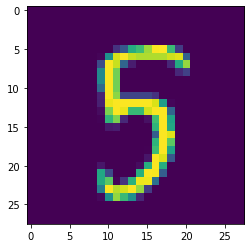

5




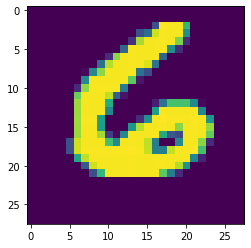

6




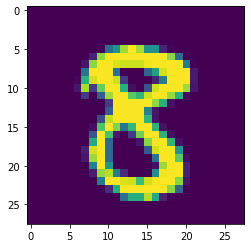

8




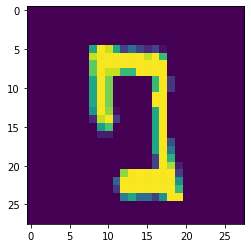

7




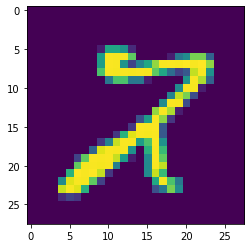

2




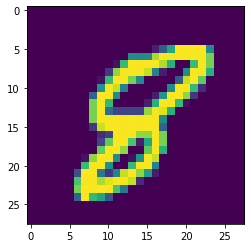

8


data shape: torch.Size([64, 1, 28, 28])
label shape: torch.Size([64])


In [4]:
import matplotlib.pyplot as plt
import numpy as np


for i, data in enumerate(train_loader):
  x, y = data
  img, label = x[0, :, :, :], y[0].item()
  
  npimg = img.numpy()
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.imshow(npimg.squeeze())
  plt.show()
  print(label)
  print('\n')
  if i == 5:
    print(f'data shape: {x.shape}')
    print(f'label shape: {y.shape}')
    break

## Training & Evaluation
Now that we have our data loaders set up we can focus on setting up training. referring to the slides we can see that the first thing we should do now is declare the model. For the purposes of this notebook we're going to use a one hidden layer neural network with relu activation. There's different ways of defining models in pytorch but for simple models like this using 'torch.nn.Sequential' is the most convenient.

In [5]:
IN_SIZE = 28*28
HIDDEN_SIZE = 1024
OUT_SIZE = 10

model = torch.nn.Sequential(
                          torch.nn.Linear(IN_SIZE, HIDDEN_SIZE),
                          torch.nn.ReLU(),
                          torch.nn.Linear(HIDDEN_SIZE, OUT_SIZE)
)
summary(model, data[0].flatten(start_dim=1))

      Kernel Shape Output Shape   Params Mult-Adds
Layer                                             
0_0    [784, 1024]   [64, 1024]  803.84k  802.816k
1_1              -   [64, 1024]        -         -
2_2     [1024, 10]     [64, 10]   10.25k    10.24k
----------------------------------------------------
                        Totals
Total params           814.09k
Trainable params       814.09k
Non-trainable params       0.0
Mult-Adds             813.056k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[784, 1024]","[64, 1024]",803840.0,802816.0
1_1,-,"[64, 1024]",NaN,NaN
2_2,"[1024, 10]","[64, 10]",10250.0,10240.0


Following the process outlined in the slides, now we declare our optimizer and loss function.

In [6]:
optimizer   = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion   = torch.nn.CrossEntropyLoss()

Now we write helper functions to train and evaluate. Although these helper functions aren't strictly necessary, the modularity leads to cleaner code which is easier to debug.

In [7]:
def train_epoch(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(data_loader)):
        images = images.to(device)
        labels = labels.to(device)

        model_out = model(images.flatten(start_dim=1))

        loss = criterion(model_out, labels)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    return train_loss

In [8]:
def eval(model, data_loader):
    model.eval()

    true_labels = []
    pred_labels = []

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(images.flatten(start_dim=1))

        preds = torch.argmax(logits, dim=1).squeeze()
        pred_labels.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
    accuracy = sklearn.metrics.accuracy_score(pred_labels, true_labels) 
    return accuracy*100

Now that we have our helper functions defined we can write our main train loop, notice how concise the loop is since we have modular training and eval functions.

In [9]:
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, optimizer, criterion, train_loader)
    val_acc    = eval(model, val_loader)
    print(f'train_loss: {train_loss} \tval_acc: {val_acc}')

  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.25441793859253325 	val_acc: 96.15


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.0945499011700352 	val_acc: 96.15


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.06068611168054243 	val_acc: 97.6


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.040700162374724944 	val_acc: 97.65


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.02827883082907647 	val_acc: 97.82499999999999


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.021821804516017437 	val_acc: 97.975


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.016576640744615966 	val_acc: 98.05833333333334


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.014528875216958113 	val_acc: 98.08333333333333


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.010981666936616724 	val_acc: 98.23333333333333


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.0066636492296917515 	val_acc: 98.0


## Testing
Now that we've finished training our model, we have to test it on our test dataset to see how it performs on completely unseen data. For this particular project, we have the ground truth labels for our test dataset so we just use our eval function with our test dataset. Generally speaking, the function you write for evaluation will be extremely similar to the function you write for testing

In [10]:
eval(model, test_loader)

98.0

## Conclusion
By going through this notebook we've seen the different stages of a deep learning project from start to finish, hopefully you can refer back to the slides and see how these different stages fit together and the role they play in the overall project.